In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.stats import norm

def BS_call_price(S, K, T, t, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.

    Parameters:
    S (float): Spot price of the underlying asset
    K (float): Strike price of the option
    T (float): Time to maturity (in years)
    t (float): Current time (usually 0 if calculating at present)
    r (float): Risk-free interest rate (annualized, expressed as a decimal)
    sigma (float): Volatility of the underlying asset (annualized, expressed as a decimal)

    Returns:
    float: Black-Scholes call option price
    """
    T = T - t  # Remaining time to maturity

    if T <= 0:  # Handle edge case where time to expiration is zero
        return max(S - K, 0)  # Call option payoff at expiration

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


In [3]:

def fBS_call_price(S, K, T, t, r, sigma, H):
    """
    Calculate the price of a European call option under the fractional Black-Scholes model.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        t (float): Current time (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility.
        H (float): Hurst parameter (0 < H < 1).

    Returns:
        float: Price of the call option.
    """
    # Time difference
    tau = T - t
    if tau <= 0:
        return max(S - K, 0)  # Handle expiry case

    # Adjusted volatility term
    sigma_adj = sigma * np.sqrt((T**(2 * H) - t**(2 * H)) / (2 * H))

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma_adj**2) * tau) / (sigma_adj * np.sqrt(tau))
    d2 = d1 - sigma_adj * np.sqrt(tau)

    # Calculate the call price
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price


In [12]:
# Define the Hurst exponent function (sinusoidal)
def h(t, A, B, C, D):
    return A * np.cos(B * t + C) + D

# Multifractional Black-Scholes Call price formula
def mBS_call_price(S0, K, T, t, r, sigma, H_params):    
    A, B, C, D = H_params
    T = T - t
    H_T = h(T, A, B, C, D)
    variance = sigma**2 * T**(2 * H_T)
    d1 = (np.log(S0 / K) + r * T + 0.5 * variance) / np.sqrt(variance)
    d2 = d1 - np.sqrt(variance)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [47]:
rBS_sigma = 0.13909780181917927
fBS_sigma, H = 0.114291368910792 ,0.25089479581588253
A, B, C, D, mBS_sigma = 0.01, 25.25842291312071, 0.28643715694060773, 0.5, 0.1390616447285243


In [48]:
import yfinance as yf

future_options = pd.read_csv('weekly_contracts_100.csv')

K = 4775.0

temp_df = future_options[future_options.Strike == K]\
    [['Maturity', 'Close']]
temp_df['Maturity'] = pd.to_datetime(temp_df['Maturity'])

temp_df = temp_df[temp_df['Maturity'] < '2024-05-01']

temp_df.sort_values(by='Maturity', inplace=True)


maturity_date = '2024-01-19'

# Download IRX and SPX data
irx = yf.download('^IRX', start='2024-01-18', end='2024-01-19')['Close']
spx = yf.download('^GSPC', start='2024-01-18', end='2024-01-19')['Close']


s0 = spx.iloc[-1].item()
r = irx.iloc[-1].item()*0.01

T = lambda x: (x - pd.to_datetime(maturity_date)).days / 365

temp_df['BS']  = temp_df["Maturity"].apply(
    lambda x: BS_call_price(s0, K, T(x), 0, r, rBS_sigma)
    )

temp_df['fBS']  = temp_df["Maturity"].apply(
    lambda x: fBS_call_price(s0, K, T(x), 0, r, fBS_sigma, H)
    )

temp_df['mBS']  = temp_df["Maturity"].apply(
    lambda x: mBS_call_price(s0, K, T(x), 0, r, mBS_sigma, (A, B, C, D))
    )




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

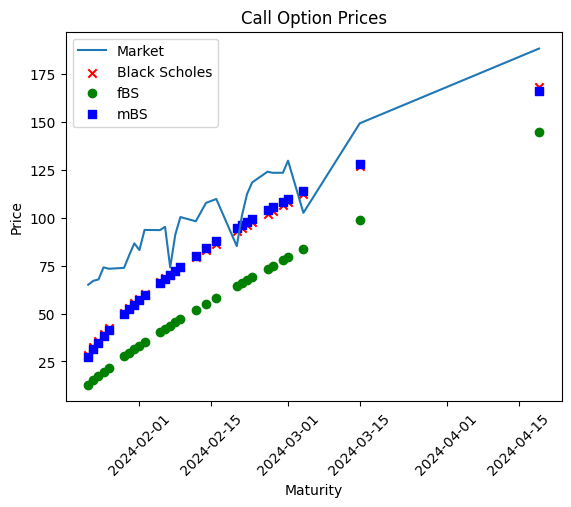

In [50]:
plt.plot(temp_df['Maturity'], temp_df['Close'], label='Market')
plt.scatter(temp_df['Maturity'], temp_df['BS'], label='BS', color='red', marker='x')
plt.scatter(temp_df['Maturity'], temp_df['fBS'], label='fBS', color='green', marker='o')
plt.scatter(temp_df['Maturity'], temp_df['mBS'], label='mBS', color='blue', marker='s')

plt.xlabel('Maturity')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(["Market", "Black Scholes", "fBS", "mBS"])
plt.title('Call Option Prices')
plt.show()
